<font size="1">Copyright 2021, by the California Institute of Technology. ALL RIGHTS RESERVED. United States Government sponsorship acknowledged. Any commercial use must be negotiated with the Office of Technology Transfer at the California Institute of Technology.</font>
    
<font size="1">This software may be subject to U.S. export control laws and regulations. By accepting this document, the user agrees to comply with all applicable U.S. export laws and regulations. User has the responsibility to obtain export licenses, or other export authority as may be required, before exporting such information to foreign countries or providing access to foreign persons.<font>

#### Source of original version of this notebook: Lavalle, Marco (JPL)
https://gitlab.com/plant/plant/-/blob/65d0312c6f16af69b3720704206e2e66304ac3cf/notebook/MAAP/demo1/maap-plant-demo_20181206.ipynb 

### Required Setup
This notebook requires the MAAP python client (maap-py). To install:

    1. Open a terminal from the jupyter notebook home page.
    2. Activate the plant conda environment by running: conda activate plant
    3. In the jovyan home directory, run: git clone https://github.com/MAAP-Project/maap-py.git
    4. Enter the newly created directory: cd maap-py
    5. Perform the installation: python setup.py install
    6. Create a copy of the maap.cfg file in the jovyan home directory: cp maap.cfg ~

Note that for step 2, you can insteada elect to create a clone of the plant environment and install maap there - see the Create_Environments notebook.

# Radar-lidar comparison using MAAP and PLAnT

_NASA-ESA Face-to-Face Meeting Demo - 6 December 2018_  

The UAVSAR radar and LVIS lidar instruments flew in 2016 over the Lope National Park, Gabon, during the joint NASA-ESA AfriSAR campaign. This exercise shows a first-order analysis of the L-band backscatter variation versus LVIS-derived mean canopy height using the PLAnT and MAAP tools. This sample notebook is for _demonstration purposes only_ of the PLAnT and MAAP tools. Processing, program interface and overall workflow are notional and will be updated in following versions of this notebook. After each PLAnT Python instruction below the equivalent shell command-line string is shown. Documentation is available by typing `plant_<command>.py --help` at command line.

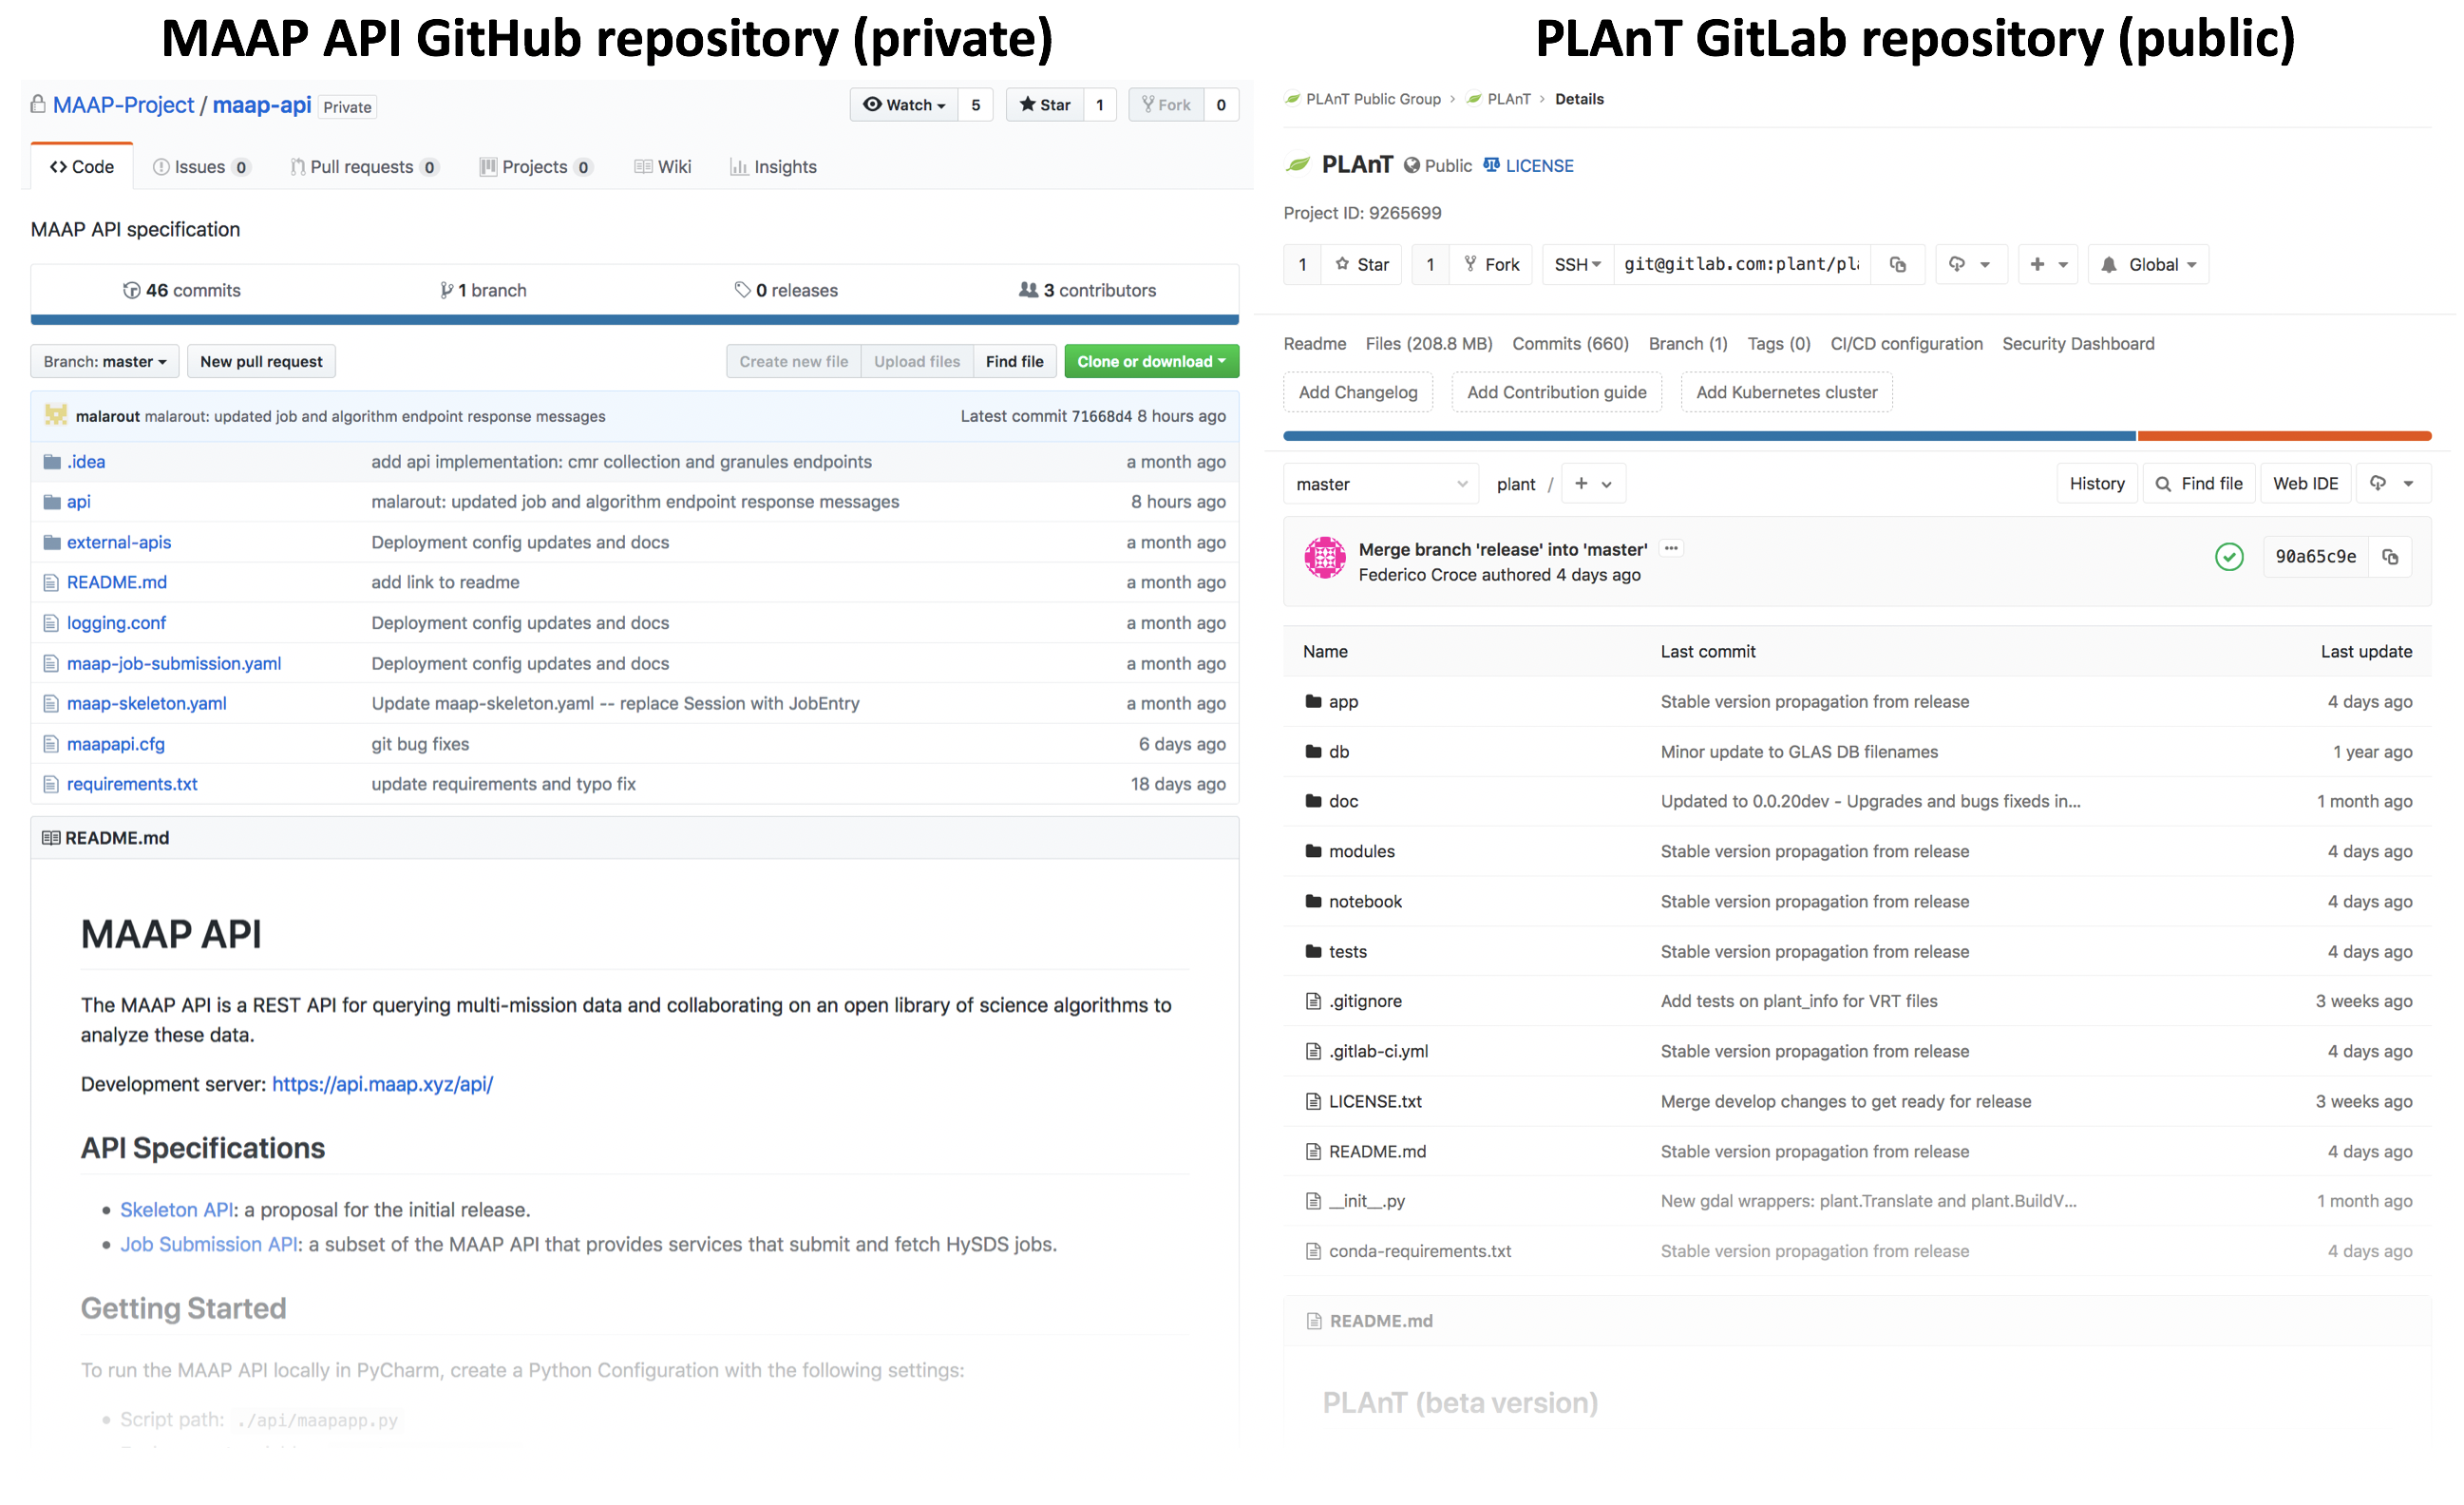

### Notebook workflow

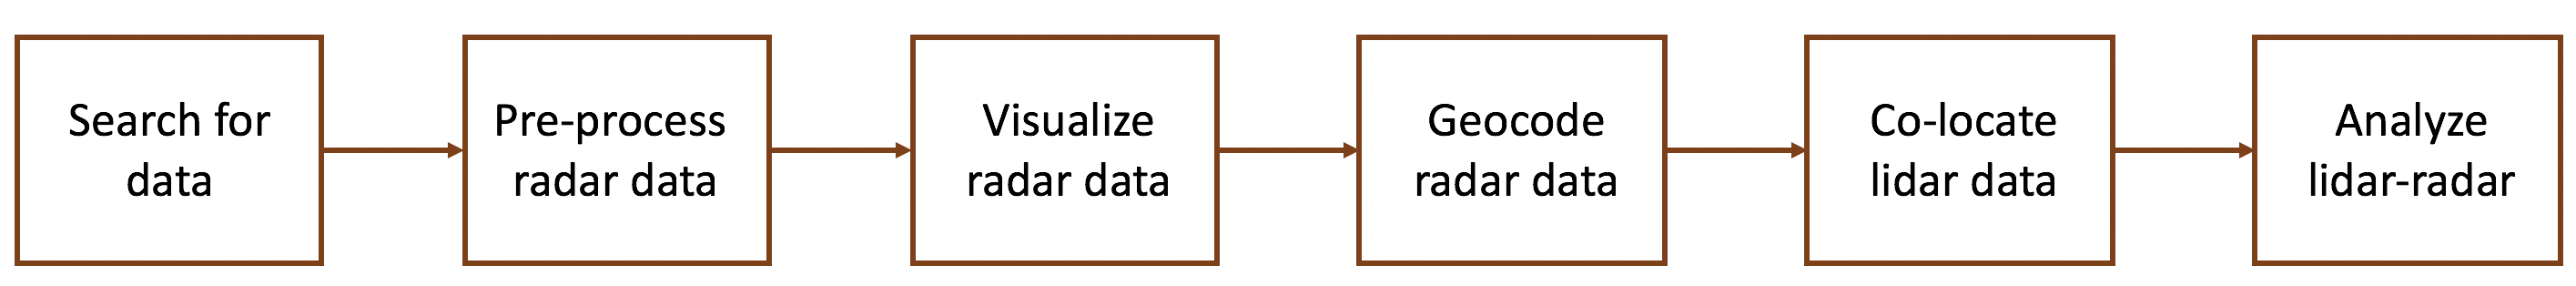

### 1. Prepare working environmentImport the Python packages needed in the workflow:

In [ ]:
import sys
sys.path.append('../')

import plant
import maap
import os
import numpy as np
from osgeo import gdal
from maap.maap import MAAP
import jwt
import datetime
import multiprocessing

# this block makes sure the directory set-up/change is only done once and relative to the notebook's directory
try:
    start_dir
except NameError:
    start_dir = os.getcwd()
    output_dir = os.path.join(start_dir, 'notebook_output/maap-plant-demo_20181206')
    os.makedirs(output_dir, exist_ok=True)

os.chdir(output_dir)
!pwd

Initialize the MAAP API

In [ ]:
# maap.cfg must be in home directory or current directory
maap = MAAP() 

## 2. Search for data within MAAP

Set up the main variables such as input data and output folder: 

In [ ]:
# Radar data
pool = multiprocessing.Pool(4)

# Radar data
radarGranules = maap.searchGranule(site_name='Lope National Park Gabon',
                                   track_number='001', 
                                   collectionConceptId='C1200000308-NASA_MAAP')
async_results = [ pool.apply_async(i.getLocalPath, (i,)) for i in radarGranules ]
pool.close()

In [ ]:
# Rdr files
pool = multiprocessing.Pool(4)

rdrFiles = maap.searchGranule(site_name='Lope National Park Gabon', data_format='rdr', collectionConceptId='C1200000308-NASA_MAAP')
async_results = [ pool.apply_async(i.getLocalPath, (i,)) for i in rdrFiles ]
pool.close()

In [ ]:
import copy

# hdrFiles
hdrFiles = copy.deepcopy(rdrFiles)
for f in hdrFiles:
    f._location = f._location + '.hdr'

hdrFiles[0]._location
pool = multiprocessing.Pool(4)
async_results = [ pool.apply_async(i.getLocalPath, (i,)) for i in hdrFiles ]
pool.close()

Download the radar granules. Note the explicit download of the SLC datafiles that are referenced in the VRT. This takes a few minutes to complete.

In [ ]:
# get the VRT
radarGranule = list(filter(lambda granule: granule._location.endswith('.vrt'), radarGranules))[0]
print(f"downloading {radarGranule._location}")
radarData = radarGranule.getLocalPath()

# get the associated SLCs
slcs_to_download = []
for slc in radarGranules:
    granule_id = slc["Granule"]["GranuleUR"]
    if (granule_id.startswith('uavsar_AfriSAR_v1_SLC-lopenp') and granule_id.endswith('slc')):
       slcs_to_download.append(slc)

for slc in slcs_to_download:
    if not os.path.exists(slc["Granule"]["GranuleUR"]):
        print(f"downloading {slc._location}")
        data = slc.getLocalPath()
    else:
        print(f"{slc._location} already exists locally, skipping.")

_ = plant.info(radarData)

In [ ]:
# Output folder and filename
croppedRadarData = os.path.join(output_dir, 'lope_afrisar_cropped.vrt')
croppedTopoData  = os.path.join(output_dir, 'topo_cropped.vrt')

**Check files are downloaded with `!ls`**

### 3. Pre-process radar data
Query the size of the input dataset using `plant_info`:

In [ ]:
_ = plant.info(radarData)

Subset the input radar data with lines and columns (lat/lon also possible) using `plant_util` or `plant_crop`:

In [ ]:
srcWin = [1200, 41000, 450, 3550] # x0,y0, width, height

_ = plant.util(radarData, 
               output=croppedRadarData, 
               srcwin=srcWin, 
               band=2, 
               force=True,
               mute=True)

Verify that cropped radat data have the correct size corresponding to `srcWin` parameters defined above:

In [ ]:
_ = plant.info(croppedRadarData)

Multi-look radar data using `plant_filter`. Selected multi-look factors allow sufficient independent looks to reduce speckle and give a sample size on the ground of approximately 17 m along azimuth.

In [ ]:
# Define multi-look factors
nlooksAzimuth = 29
nlooksRange = 5

radarDirMLK  = os.path.join(output_dir, f'covdir_r{nlooksRange}_a{nlooksAzimuth}')
radarFileMLK ='topo_mlk.bin'
mlkRadarData = os.path.join(radarDirMLK, radarFileMLK)

# Multi-look
result = plant.filter(croppedRadarData, 
                      output_dir=radarDirMLK, 
                      transform_square=True, 
                      force=True,
                      nlooks=[nlooksAzimuth, nlooksRange], 
                      separate=True, 
                      output_file=radarFileMLK, 
                      output_format='ENVI', 
                      mute=True)

Multi-look topo layers used below for resampling. Topo layers could be re-generated by importing `isce`. Use multi-look here for simplicity.

Verify that number of lines and columns changed after multi-looking:

In [ ]:
_ = plant.info(mlkRadarData)

## 4. Visualize radar data
Use `plant_display` to visualize radar backscatter and the local radar incidence  (band 5).

In [ ]:
%matplotlib inline
_ = plant.display(mlkRadarData, 
                  label_colorbar='Radar Backscatter [dB]',
                  title='',
                  mute=True, dB=True)

<font size="1">This notebook is compatible with NISAR Jupyter Server Stack v1.4 and above</font>